In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 21:33:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import tensorflow as tf
# from tensorflow import keras

# # Import training set images
# train_set = keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ASLSplit/train', labels='inferred', label_mode='categorical',
#                                                               image_size=(224, 224), batch_size=32, shuffle=True, seed=42)

# # Import validation set images
# val_set = keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ASLSplit/val', labels='inferred', label_mode='categorical',
#                                                               image_size=(224, 224), batch_size=32, shuffle=True, seed=42)

# # Import test set images
# test_set = keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ASLSplit/test', labels='inferred', label_mode='categorical',
#                                                               image_size=(224, 224), batch_size=32, shuffle=True, seed=42)

Found 116046 files belonging to 28 classes.
Found 24864 files belonging to 28 classes.
Found 24872 files belonging to 28 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import os
import glob

import numpy as np
import pandas as pd

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/ASLSplit/train'
VAL_DIR = '/content/drive/MyDrive/ASLSplit/val'
TEST_DIR = '/content/drive/MyDrive/ASLSplit/test'
EXAMPLES_DIR = '/content/drive/MyDrive/ASLSplit/examples' # images from training set for visualization purpose only

# Load all the images under each class (subdirectory)
def load_images(base_dir, directories_as_labels=True, files='**/*.jpg'):
  filenames = glob.glob(os.path.join(base_dir, files))

  # Load all the subdirectories as classes
  classes = (os.path.basename(os.path.dirname(name)) for name in filenames)
  df = pd.DataFrame(list(zip(filenames, classes)), columns=['path', 'label'])

  return df

train_df = load_images(TRAIN_DIR)
val_df = load_images(VAL_DIR)
test_df = load_images(TEST_DIR)
examples_df = load_images(EXAMPLES_DIR)

In [ ]:
batch_size = 32
image_size = 224
n_classes = 28

train_datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2, rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

examples_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR, target_size=(image_size,image_size), batch_size=batch_size,
                        class_mode='categorical', color_mode='rgb', shuffle=True)

val_generator = val_datagen.flow_from_directory(directory=VAL_DIR, target_size=(image_size,image_size), batch_size=batch_size,
                        class_mode='categorical', color_mode='rgb', shuffle=True)

examples_generator = examples_datagen.flow_from_directory(directory=EXAMPLES_DIR, target_size=(image_size,image_size), batch_size=batch_size,
                        class_mode='categorical', color_mode='rgb', shuffle=True)

Found 116046 images belonging to 28 classes.
Found 24864 images belonging to 28 classes.
Found 52 images belonging to 28 classes.


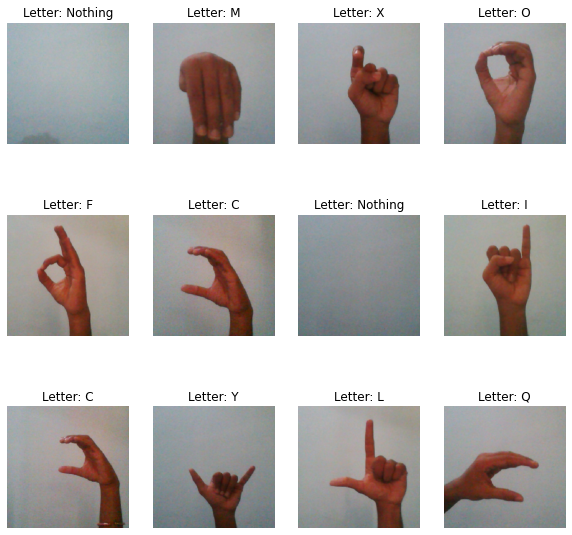

In [ ]:
import matplotlib.pyplot as plt

x_batch, y_batch = examples_generator.next()
class_names = examples_generator.class_indices

plt.figure(figsize=(10, 10))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_batch[i].astype("uint8"))
    letter = list(class_names.keys())[list(class_names.values()).index(y_batch[i].argmax())]
    plt.title(f"Letter: {letter}")
    plt.axis("off")

# DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Dropout

from keras.models import Model

from tensorflow.keras.optimizers import Adam

In [ ]:
# Set pre-trained Densenet model as base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze DenseNet121 model
base_model.trainable = False

model = base_model.output

# Add to pre-trained Densenet model
model = GlobalAveragePooling2D()(model)
model = BatchNormalization()(model)
model = Dropout(0.2)(model)
model = Dense(1024,activation='relu')(model) 
model = Dense(512,activation='relu')(model) 
model = BatchNormalization()(model)
model = Dropout(0.2)(model)

output = Dense(n_classes, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
def compile_model(model):
    optimizer=Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def train_model(model, train_set, val_set):
    history = model.fit(train_set, epochs=2, verbose=2, validation_data=val_set, shuffle=True) # batch_size not specified because images are in dataset form

    return history

def eval_model(model, test_set):
    test_loss, test_accuracy = model.evaluate(test_set)

    return test_loss, test_accuracy

In [ ]:
# model = compile_model(model)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=5, verbose=2, validation_data=val_generator, shuffle=True)

# save the model
model.save('densenet_baseline.h5')

# summarize history for accuracy

plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

Epoch 1/5
